# Load Data

- Use model trained by V2Ray server in AWS to classify data from V2Ray server in GCE.

In [1]:
# v2ray traffic tag
V2RAY_HOST_TAG =  # For privacy concern, please provide "Your-V2Ray-Server-IP-and-Port"
# modified packet data from Google Compute Engine
DATA_ROOT = '/src/data/tcpsorter/mod-tcpsorter.gce'

In [2]:
import numpy as np
import math
from pathlib import Path
from tensorflow.keras.utils import Sequence

# packet data size
FIXED_PACKET_SIZE = 1500
NUM_OF_PACKETS_PER_FILE = 16
# rescale factor for packet data byte
RESCALE_FACTOR = np.float32(1./255)
# training data vs validation data
TRAINING_DATA_PERCENTAGE = 0.8
# modified packet file extension
PACKET_FILE_EXT = '*.bin'


def rglob(data_root, file_ext):
    files = list()
    for filePath in Path(data_root).rglob(file_ext):
        files.append(str(filePath))
    return files


def binary_classification(packet_path, match_string=V2RAY_HOST_TAG):
    """Binary network traffic classification function

    :param packet_path: file path to packet
    :param match_string:
    :return: 1, if it is v2ray traffice. 0, otherwise.
    """
    if packet_path.find(match_string) != -1:
        return 1
    else:
        return 0


def generate_v2ray_packet_path_list(data_root=DATA_ROOT, is_v2ray=True):
    file_list = rglob(data_root, PACKET_FILE_EXT)
    if is_v2ray:
        bool_value_class = 1
        string_format = 'Total v2ray traffic %d'
    else:
        bool_value_class = 0
        string_format = 'Total non v2ray traffic %d'
    file_cat_list = [file_path for file_path in file_list if binary_classification(file_path) == bool_value_class]
    file_cat_list.sort()
    print(string_format % len(file_cat_list))
    return file_cat_list


def generate_train_validation_packet_path_list(data_root=DATA_ROOT, training_pct=TRAINING_DATA_PERCENTAGE, eqaul_size=True):
    file_list = rglob(data_root, PACKET_FILE_EXT)
    v2ray_file_list = [file_path for file_path in file_list if binary_classification(file_path) == 1]
    non_v2ray_file_list = [file_path for file_path in file_list if binary_classification(file_path) == 0]
    v2ray_file_list.sort()
    non_v2ray_file_list.sort()

    if eqaul_size:
        cut_off_count = min(len(v2ray_file_list), len(non_v2ray_file_list))
        v2ray_file_size = cut_off_count
        non_v2ray_file_size = cut_off_count
    else:
        v2ray_file_size = len(v2ray_file_list)
        non_v2ray_file_size = len(non_v2ray_file_list)

    v2ray_indexes = np.arange(len(v2ray_file_list))
    np.random.shuffle(v2ray_indexes)
    non_v2ray_indexes = np.arange(len(non_v2ray_file_list))
    np.random.shuffle(non_v2ray_indexes)

    training_file_list = [v2ray_file_list[index]
                          for index in v2ray_indexes[:math.ceil(v2ray_file_size * training_pct)]] + \
                         [non_v2ray_file_list[index]
                          for index in non_v2ray_indexes[:math.ceil(non_v2ray_file_size * training_pct)]]

    validation_file_list = [v2ray_file_list[index]
                            for index in v2ray_indexes[math.ceil(v2ray_file_size * training_pct): v2ray_file_size]] + \
                           [non_v2ray_file_list[index]
                            for index in non_v2ray_indexes[math.ceil(non_v2ray_file_size * training_pct): non_v2ray_file_size]]

    print("Statistics: ")
    print("Total V2ray traffic %d, Total non-V2ray traffic %d" % (len(v2ray_file_list), len(non_v2ray_file_list)))
    print("Output train traffic %d, Total validation traffic %d" % (len(training_file_list), len(validation_file_list)))

    return training_file_list, validation_file_list


class PacketDataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, data_path_list, classification_func=binary_classification, rescale=RESCALE_FACTOR,
                 batch_size=32, dim=(NUM_OF_PACKETS_PER_FILE, FIXED_PACKET_SIZE), shuffle=True, predict=False):
        """Initialization

        :param data_path_list: list of data path
        :param classification_func: binary classification function
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating data dimension
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.data_path_list = data_path_list
        self.classification_func = classification_func
        self.rescale = rescale
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.predict = predict
        self.indexes = np.arange(len(self.data_path_list))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number samples of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.data_path_list) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate sub packet path list
        data_path_sub_list = [self.data_path_list[k] for k in indexes]

        # Generate data
        x = self.standardize(self._generate_x(data_path_sub_list))
        if self.predict:
            return x
        else:
            y = self._generate_y(data_path_sub_list)
            return x, y

    def standardize(self, x):
        if self.rescale:
            x *= self.rescale
        return x

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_x(self, file_path_list):
        """Generates data containing batch_size data

        :param file_path_list: file path list
        :return: batch of data
        """
        # Initialization
        x = np.empty((self.batch_size, *self.dim), dtype=np.float32)

        # Generate data
        for i, file_path in enumerate(file_path_list):
            # Store sample
            x[i, ] = self._load_packet(file_path)

        return x

    def _generate_y(self, file_path_list):
        """Generates data containing batch_size

        :param file_path_list: file path list
        :return: batch if masks
        """
        y = np.empty((self.batch_size, ), dtype=np.float32)

        # Generate data
        for i, file_path in enumerate(file_path_list):
            y[i, ] = self.classification_func(file_path)

        return y

    def _load_packet(self, packet_path):
        """Load packet

        :param packet_path: path to packet
        :return: packet in numpy array
        """
        packet_dt = np.dtype((np.uint8, FIXED_PACKET_SIZE))
        packet_data = np.fromfile(packet_path, dtype=packet_dt, count=NUM_OF_PACKETS_PER_FILE)
        return packet_data.astype(np.float32)


# Load Previously Trained Model

- Classify the traffic data from Google Compute Engine by model trained by the traffic data from AWS

In [3]:
from keras.models import load_model

model = load_model('/src/data/tcpsorter/model/v2ray_classifier_equal_sample.h5')

Using TensorFlow backend.


In [4]:
# Create tes data generator
v2ray_packet_file_list = generate_v2ray_packet_path_list()
non_v2ray_packet_file_list = generate_v2ray_packet_path_list(is_v2ray=False)
v2ray_generator = PacketDataGenerator(v2ray_packet_file_list, shuffle=False)
non_v2ray_generator = PacketDataGenerator(non_v2ray_packet_file_list, shuffle=False)

Total v2ray traffic 780
Total non v2ray traffic 3241


# Generate Adversarial Examples

## FGSM Approach

- Fast Gradient Sign Method. See [paper](https://arxiv.org/abs/1412.6572).

In [5]:
import keras.backend as K
import tensorflow as tf
import keras
print('keras version: %s' % keras.__version__)
print('tensorflow version: %s' % tf.__version__)

keras version: 2.3.1
tensorflow version: 2.0.0


In [6]:
x, y = v2ray_generator.__getitem__(0)
len(v2ray_generator)

24

In [7]:
def print_detail(var):
    if var.shape is not None:
        print('shape: ', var.shape)
    if var.dtype is not None:
        print('dtype: ', var.dtype)
    print('type: ', type(var))
    print('content: ', var)

In [8]:
# 32 samples in each batch, 16 packets in each connection, 1500 byte in each packet
print_detail(x)
print_detail(y)

shape:  (32, 16, 1500)
dtype:  float32
type:  <class 'numpy.ndarray'>
content:  [[[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.00784314 ... 0.         0.         0.        ]
  ...
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]]

 [[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.00784314 ... 0.         0.         0.        ]
  ...
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]]

 [[0.27058825 0.

## Pick the first input as an example

In [9]:
# pick first example
x_in = x[0:1, ]
print_detail(x_in)

shape:  (1, 16, 1500)
dtype:  float32
type:  <class 'numpy.ndarray'>
content:  [[[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.00784314 ... 0.         0.         0.        ]
  ...
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]]]


In [10]:
y_pre = model.predict(x_in)
print_detail(y_pre)

shape:  (1, 1)
dtype:  float32
type:  <class 'numpy.ndarray'>
content:  [[1.]]


### Ricky's Comment

- The prediction from trained model is 1, which matches the true V2Ray traffic label. 
- Now we want to modify input x so that the prediction is 0. In other word, the probability of V2Ray traffic is 0.

In [11]:
# Compute adversaril sign gradient
@tf.function
def adversarial_sign_gradient(x, y_target, trained_model=model):
    x = tf.cast(x, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = trained_model(x)
        loss_value = tf.keras.losses.binary_crossentropy(y_target, y_pred)
    
    gradient = tape.gradient(loss_value, x)
    signed_grad = tf.cast(tf.math.sign(gradient), dtype=tf.int32)
    return signed_grad

In [12]:
adv_sign = adversarial_sign_gradient(x_in, np.array([[0.]])).numpy()

In [13]:
print_detail(adv_sign)

shape:  (1, 16, 1500)
dtype:  int32
type:  <class 'numpy.ndarray'>
content:  [[[-1 -1 -1 ... -1 -1 -1]
  [-1 -1 -1 ...  1  1  1]
  [-1 -1 -1 ... -1 -1 -1]
  ...
  [-1 -1 -1 ... -1  1  1]
  [-1 -1 -1 ... -1  1 -1]
  [ 0  0  0 ...  0  0  0]]]


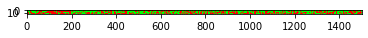

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

COLOR_MAP = {
    1: [255, 0, 0], # Red
    -1: [0, 255, 0], # Green
    0: [0, 0, 255]} # Blue


def convert_rgb(f_img, color_map=COLOR_MAP, border_color=(0, 0, 0), border_row_num=1, add_border=False):
    rows = f_img.shape[0]
    if add_border:
        rows += 1
    cols = f_img.shape[1]
    c_img = np.ndarray(shape=(rows, cols, 3), dtype=np.uint8)
    for x in range(rows):
        if add_border and x == rows - 1:
            for y in range(cols):
                c_img[x, y, 0] = border_color[0]
                c_img[x, y, 1] = border_color[1]
                c_img[x, y, 2] = border_color[2]
        else:
            for y in range(cols):
                rgb = COLOR_MAP.get(f_img[x, y])
                c_img[x, y, 0] = rgb[0]
                c_img[x, y, 1] = rgb[1]
                c_img[x, y, 2] = rgb[2]
    return c_img



#plt.imshow(color_img)
#print(np.histogram(adv_sign[0, ].flatten(), bins=4))
#plt.hist(adv_sign[0, ].flatten(), bins='auto')

def save_color_img_to_png(color_img, file_name):
    img = Image.fromarray(color_img, 'RGB')
    img.save(file_name)

def show_png(file_name):
    plt_img = mpimg.imread(output_file_name)
    plt.imshow(plt_img)

output_file_name = 'adv_signed_gradient.png'
color_img = convert_rgb(adv_sign[0,])
save_color_img_to_png(color_img, output_file_name)
show_png(output_file_name)


### Ricky's Comment

- To visualize the sign gradient, we plot the graph in RGB. Red is 1, green is -1, blue is 0.
- There is no change in the last packet i.e. the 16th packet.

In [15]:
# floating point precision in one byte
1/255.0

0.00392156862745098

## Tensorflow version

In [16]:
# tf version
def get_adversarial_noise(x, y_target, model, mu = 1e-4, debug=False):
    x = tf.cast(x, dtype=tf.float32)
    y_target = tf.cast(y_target, dtype=tf.float32)
    epsilons = np.arange(1.0, 100.0) * 1/255.0
    adv_sign_grad = adversarial_sign_gradient(x, y_target)
    
    for i, eps in enumerate(epsilons.tolist()):
        adv_noise = eps * tf.cast(adv_sign_grad, dtype=tf.float32)
        x_adv = x - adv_noise
        #print('x_adv: ', x_adv)
        y_pre = tf.cast(model.predict(x_adv.numpy()), dtype=tf.float32)
        if debug:
            print('i: %d, eps: %f, y: %f' % (i, eps, y_pre.numpy()))
            
        mu = tf.ones(shape=y_pre.shape, dtype=y_pre.dtype) * mu
        if not tf.math.reduce_any(tf.math.less(mu, tf.math.abs(y_pre - y_target))):
            return adv_noise, i + 1, adv_sign_grad

# the target is 0!
adv_noise, adv_units, adv_sign_grad = get_adversarial_noise(x_in, np.array([[0.]]), model, debug=True)

print('Adversarial Noise: ', adv_noise)
print('Adversarial Signed Gradient: ', adv_sign_grad)

i: 0, eps: 0.003922, y: 1.000000
i: 1, eps: 0.007843, y: 1.000000
i: 2, eps: 0.011765, y: 1.000000
i: 3, eps: 0.015686, y: 1.000000
i: 4, eps: 0.019608, y: 0.999998
i: 5, eps: 0.023529, y: 0.999832
i: 6, eps: 0.027451, y: 0.988524
i: 7, eps: 0.031373, y: 0.560655
i: 8, eps: 0.035294, y: 0.022499
i: 9, eps: 0.039216, y: 0.000566
i: 10, eps: 0.043137, y: 0.000014
Adversarial Noise:  tf.Tensor(
[[[-0.04313726 -0.04313726 -0.04313726 ... -0.04313726 -0.04313726
   -0.04313726]
  [-0.04313726 -0.04313726 -0.04313726 ...  0.04313726  0.04313726
    0.04313726]
  [-0.04313726 -0.04313726 -0.04313726 ... -0.04313726 -0.04313726
   -0.04313726]
  ...
  [-0.04313726 -0.04313726 -0.04313726 ... -0.04313726  0.04313726
    0.04313726]
  [-0.04313726 -0.04313726 -0.04313726 ... -0.04313726  0.04313726
   -0.04313726]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]], shape=(1, 16, 1500), dtype=float32)
Adversarial Signed Gradient:  tf.Tensor(
[[[-1 -1 -1 ... -1 -1 -1]
  [

### Ricky's Comment

- We need to multiple `11` (i = 10) on discrete floating point precision `0.003922` (1/255.0) to make the prediction closing to 0 (`0.00014` < `1e-4`).

## Modify Original Data Packet

- Apply adversarial signed gradient on the original packet data from rage [0, 255]
- Set `adv_noise` with floor = 0 and ceiling = 255

In [17]:
original_packet_generator = PacketDataGenerator(v2ray_packet_file_list, shuffle=False, rescale=None)
x_org, y_org = original_packet_generator.__getitem__(0)

x_org_in = x_org[0:1, ]
y_org_true = y_org[0:1, ]
print('Original x')
print_detail(x_org_in)

print('\n\nOriginal y_true')
print_detail(y_org_true)

Original x
shape:  (1, 16, 1500)
dtype:  float32
type:  <class 'numpy.ndarray'>
content:  [[[69.  0.  1. ...  0.  0.  0.]
  [69.  0.  5. ...  0.  0.  0.]
  [69.  0.  2. ...  0.  0.  0.]
  ...
  [69.  0.  5. ...  0.  0.  0.]
  [69.  0.  5. ...  0.  0.  0.]
  [69.  0.  5. ...  0.  0.  0.]]]


Original y_true
shape:  (1,)
dtype:  float32
type:  <class 'numpy.ndarray'>
content:  [1.]


In [18]:
x_org_in_masq = x_org_in - adv_sign_grad.numpy() * 12
print('Masqueraded x: ')
print_detail(x_org_in_masq)

Masqueraded x: 
shape:  (1, 16, 1500)
dtype:  float64
type:  <class 'numpy.ndarray'>
content:  [[[ 81.  12.  13. ...  12.  12.  12.]
  [ 81.  12.  17. ... -12. -12. -12.]
  [ 81.  12.  14. ...  12.  12.  12.]
  ...
  [ 81.  12.  17. ...  12. -12. -12.]
  [ 81.  12.  17. ...  12. -12.  12.]
  [ 69.   0.   5. ...   0.   0.   0.]]]


In [19]:
print('Non-normalized prediction: ', model.predict(x_org_in_masq * RESCALE_FACTOR))
print('Original prediction: ', model.predict(x_org_in * RESCALE_FACTOR))

Non-normalized prediction:  [[3.5589628e-07]]
Original prediction:  [[1.]]


In [20]:
# min(max(x, 0), 255)
np_floor = np.zeros(shape=x_org_in_masq.shape, dtype=x_org_in_masq.dtype)
np_cap = np.ones(shape=x_org_in_masq.shape, dtype=x_org_in_masq.dtype) * 255

x_org_noramlized = np.minimum(np.maximum(x_org_in_masq, np_floor), np_cap)
print('Normalized x:')
print_detail(x_org_noramlized)

Normalized x:
shape:  (1, 16, 1500)
dtype:  float64
type:  <class 'numpy.ndarray'>
content:  [[[81. 12. 13. ... 12. 12. 12.]
  [81. 12. 17. ...  0.  0.  0.]
  [81. 12. 14. ... 12. 12. 12.]
  ...
  [81. 12. 17. ... 12.  0.  0.]
  [81. 12. 17. ... 12.  0. 12.]
  [69.  0.  5. ...  0.  0.  0.]]]


In [21]:
print('Updated prediction: ', model.predict(x_org_noramlized * RESCALE_FACTOR))
print('Original prediction: ', model.predict(x_org_in * RESCALE_FACTOR))

Updated prediction:  [[0.00043797]]
Original prediction:  [[1.]]


## How about the whole batch?

In [22]:
# batch version
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
y_target_tensor = tf.zeros((32, 1), dtype=tf.float32)
adv_sign_grad_tensor= adversarial_sign_gradient(x_tensor, y_target_tensor)

In [23]:
print('x_tensor.shape: ', x_tensor.shape)
print('y_target_tensor.shape: ', y_target_tensor.shape)
print('adv_sign_grad_tensor.shape: ', adv_sign_grad_tensor.shape)

x_tensor.shape:  (32, 16, 1500)
y_target_tensor.shape:  (32, 1)
adv_sign_grad_tensor.shape:  (32, 16, 1500)


In [24]:
adv_sign_grad_ndarray = adv_sign_grad_tensor.numpy()
print('adv_sign_grad_ndarray.shape: ', adv_sign_grad_ndarray.shape)
batch = adv_sign_grad_ndarray.shape[0]

c_images = list()
for b in range(batch):
    f_img = adv_sign_grad_ndarray[b, ]
    c_img = convert_rgb(f_img, add_border=True)
    c_images.append(c_img)

adv_sign_grad_ndarray.shape:  (32, 16, 1500)


In [25]:
overall_image = np.concatenate(c_images)

In [26]:
print(overall_image.shape)

(544, 1500, 3)


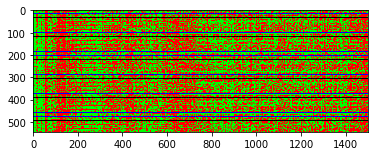

In [27]:
output_file_name = 'adv_signed_gradient_overall.png'

save_color_img_to_png(overall_image, output_file_name)
show_png(output_file_name)

In [28]:
y_pred_tensor = tf.convert_to_tensor(model.predict(x_tensor.numpy()), dtype=tf.float32)
print(y_pred_tensor)

tf.Tensor(
[[1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [0.9987436]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]], shape=(32, 1), dtype=float32)


In [29]:
adv_noise_units = tf.constant(1/255.0 * 12.0, dtype=tf.float32)
x_adv_tensor = x_tensor - adv_noise_units * tf.cast(adv_sign_grad_tensor, dtype=tf.float32)
y_adv_pred_tensor = model.predict(x_adv_tensor.numpy())
print(y_adv_pred_tensor)

[[3.5762787e-07]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.9406967e-08]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.7120113e-06]
 [0.0000000e+00]
 [8.1419945e-05]
 [0.0000000e+00]
 [1.1920929e-07]
 [0.0000000e+00]
 [3.5226345e-05]
 [0.0000000e+00]
 [5.9235096e-04]
 [1.8671155e-04]
 [2.2042274e-02]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.2387199e-07]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]


### Ricky's Comment

- To visualize the sign gradient of 32 samples, we plot the graph in RGB. Red is 1, green is -1, blue is 0, black is a boderline to separate sample.
- There is no change in the last packet i.e. the 16th packet.
- From my eyeballs, there is a common pattern among 32 samples. Would it be possible to find a universal adversarial noise to apply to all input X?

## Deepfool Approach

- Deepfool. See [paper](https://arxiv.org/abs/1511.04599)

In [30]:
# model(x) -> y , where y in [0, 1]
# f(model(x)) = 2 * model(x) - 1, f(x) in [-1, 1]
def map_func(x):
    return tf.constant(2.0, dtype=tf.float32) * x - tf.constant(1.0, dtype=tf.float32)

@tf.function
def model_gradient(x_in, trained_model=model):
    x = tf.cast(x_in, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = trained_model(x)
        y_map = map_func(y_pred)
    gradient = tape.gradient(y_map, x)
    return gradient

In [31]:
# batch version
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
gradient_tensor = model_gradient(x_tensor)
print('x_tensor: ', x_tensor)
print('gradient_tensor: ', gradient_tensor)

x_tensor:  tf.Tensor(
[[[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.00784314 ... 0.         0.         0.        ]
  ...
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]]

 [[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.00784314 ... 0.         0.         0.        ]
  ...
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]
  [0.27058825 0.         0.01960784 ... 0.         0.         0.        ]]

 [[0.27058825 0.         0.00392157 ... 0.         0.         0.        ]


In [32]:
print(model.predict(x_tensor.numpy()))

[[1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [0.9987436]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]
 [1.       ]]


In [33]:
def almost_equals(a, b, decimal=6):
    try:
        np.testing.assert_almost_equal(a, b, decimal=decimal)
    except AssertionError:
        return False
    return True

def detect_zeros(input_tensor, num_decimal=20):
    # comparing to zeros:
    zeros_like = np.zeros_like(input_tensor.numpy())  
    for decimal in range(num_decimal, 0, -1):
        print('decimal: {0}: {1}'.format(decimal,
                                         almost_equals(zeros_like,
                                                       input_tensor.numpy(),
                                                       decimal=decimal)))
detect_zeros(gradient_tensor, 20)

decimal: 20: False
decimal: 19: False
decimal: 18: False
decimal: 17: False
decimal: 16: False
decimal: 15: False
decimal: 14: False
decimal: 13: False
decimal: 12: False
decimal: 11: False
decimal: 10: False
decimal: 9: False
decimal: 8: False
decimal: 7: False
decimal: 6: False
decimal: 5: False
decimal: 4: False
decimal: 3: False
decimal: 2: True
decimal: 1: True


### Ricky's Comment

- The forward gradient looks like a zero tensor. It is caused by the vanishing gradient in the sigmoid activation function of the output layer. The sigmoid function satuarates at both ends.
- There is numerical difficulty in DeepFool and JASM approach.